In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import shap
import ast
import toolz
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from scipy.stats import pearsonr,spearmanr
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.compose import TransformedTargetRegressor
from utils import RHCF

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path_inputs="dataset_features/"
#results="results.xlsx"
model="XGB_13_3"
results="results_no_5_features_DS_noCL_finoa_13_3.xlsx"

In [4]:
features_todrop=["N1-N3_Hbond",
                 'O_Hbond',
                 'Pi-Pi_Stacking',
                 'Stacking_Alifatico',
                 'Pi_Cation']

In [5]:
NNB_radius=model.split("_")[1]
N5_radius=model.split("_")[2]

In [6]:
data=pd.read_excel("outputs/new_scans_May_2022/"+results).drop("Unnamed: 0",axis=1).set_index("name_model_radius")
best_params=ast.literal_eval(data.loc[model]["Best_params"])
best_params=toolz.keymap(lambda x: x.split("__")[2], best_params)
best_params

{'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 10,
 'n_estimators': 100}

In [7]:
best_model=XGBRegressor(**best_params)
best_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_delta_step=None, max_depth=4,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [8]:
file_name="dataset_protein_"+str(NNB_radius)+"_"+str(N5_radius)+".xlsx"
df_pm=pd.read_excel(path_inputs+file_name,sheet_name="Sheet1",index_col=0).drop(features_todrop,axis=1)
df_pm

,Em,pH,_PolarityC3,_NormalizedVDWVC1,_NormalizedVDWVC2,_NormalizedVDWVC3,_HydrophobicityC1,_HydrophobicityC2,_HydrophobicityC3,Bar.ALA,...,_SolventAccessibilityC2,_SolventAccessibilityC3,_SecondaryStrC1,_SecondaryStrC2,_SecondaryStrC3,_ChargeC1,_ChargeC2,_ChargeC3,_PolarityC1,_PolarityC2
PDB ID,,,,,,,,,,,,,,,,,,,,,
1AHN,-343.5,NaN,0.11,0.40,0.36,0.22,0.34,0.36,0.31,5.00,...,0.34,0.18,0.41,0.31,0.28,0.08,0.72,0.21,0.34,0.18
1AKR,-310.5,7.0,0.08,0.48,0.33,0.17,0.31,0.40,0.29,2.00,...,0.31,0.16,0.40,0.29,0.32,0.08,0.72,0.20,0.32,0.14
1AKT,-297.5,7.0,0.08,0.47,0.33,0.17,0.32,0.40,0.29,1.00,...,0.32,0.16,0.39,0.29,0.33,0.08,0.72,0.20,0.32,0.15
1AKW,-320.0,7.0,0.08,0.47,0.33,0.17,0.31,0.40,0.29,1.00,...,0.31,0.16,0.40,0.29,0.32,0.08,0.72,0.20,0.33,0.14
1AZL,-316.0,7.0,0.08,0.47,0.33,0.17,0.31,0.40,0.29,1.00,...,0.31,0.16,0.39,0.29,0.32,0.08,0.72,0.20,0.33,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5URE,-154.0,7.4,0.15,0.35,0.36,0.28,0.33,0.38,0.29,8.50,...,0.33,0.26,0.46,0.27,0.27,0.11,0.74,0.14,0.34,0.20
5YAK,-215.0,7.4,0.19,0.29,0.41,0.29,0.32,0.33,0.34,1.00,...,0.32,0.26,0.47,0.31,0.22,0.15,0.74,0.11,0.38,0.21
6DVI,-149.0,NaN,0.12,0.46,0.30,0.23,0.26,0.45,0.29,6.33,...,0.26,0.24,0.42,0.27,0.31,0.09,0.79,0.12,0.33,0.15


In [9]:
X=df_pm.iloc[:,1:].values
y=df_pm.iloc[:,0].values

In [10]:
X2_df=df_pm.copy()
X2_df=X2_df.reset_index()
X2_df=X2_df.drop(["PDB ID","Em"],axis=1)
X2_df

,pH,_PolarityC3,_NormalizedVDWVC1,_NormalizedVDWVC2,_NormalizedVDWVC3,_HydrophobicityC1,_HydrophobicityC2,_HydrophobicityC3,Bar.ALA,Protein.ALA,...,_SolventAccessibilityC2,_SolventAccessibilityC3,_SecondaryStrC1,_SecondaryStrC2,_SecondaryStrC3,_ChargeC1,_ChargeC2,_ChargeC3,_PolarityC1,_PolarityC2
0,NaN,0.11,0.40,0.36,0.22,0.34,0.36,0.31,5.00,15.00,...,0.34,0.18,0.41,0.31,0.28,0.08,0.72,0.21,0.34,0.18
1,7.0,0.08,0.48,0.33,0.17,0.31,0.40,0.29,2.00,18.00,...,0.31,0.16,0.40,0.29,0.32,0.08,0.72,0.20,0.32,0.14
2,7.0,0.08,0.47,0.33,0.17,0.32,0.40,0.29,1.00,17.00,...,0.32,0.16,0.39,0.29,0.33,0.08,0.72,0.20,0.32,0.15
3,7.0,0.08,0.47,0.33,0.17,0.31,0.40,0.29,1.00,17.00,...,0.31,0.16,0.40,0.29,0.32,0.08,0.72,0.20,0.33,0.14
4,7.0,0.08,0.47,0.33,0.17,0.31,0.40,0.29,1.00,17.00,...,0.31,0.16,0.39,0.29,0.32,0.08,0.72,0.20,0.33,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,7.4,0.15,0.35,0.36,0.28,0.33,0.38,0.29,8.50,47.00,...,0.33,0.26,0.46,0.27,0.27,0.11,0.74,0.14,0.34,0.20
167,7.4,0.19,0.29,0.41,0.29,0.32,0.33,0.34,1.00,12.17,...,0.32,0.26,0.47,0.31,0.22,0.15,0.74,0.11,0.38,0.21
168,NaN,0.12,0.46,0.30,0.23,0.26,0.45,0.29,6.33,47.33,...,0.26,0.24,0.42,0.27,0.31,0.09,0.79,0.12,0.33,0.15
169,7.0,0.12,0.32,0.41,0.26,0.33,0.32,0.35,5.00,6.00,...,0.33,0.18,0.35,0.38,0.26,0.11,0.75,0.14,0.38,0.19


In [11]:
r=best_model
r.fit(X,y)
subset=X #shap.sample(X,100)
explainer=shap.KernelExplainer(r.predict,(subset))
shap_values = explainer.shap_values(subset)

Using 171 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/171 [00:00<?, ?it/s]

In [12]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X2_df.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
features_graph=feature_importance["col_name"]

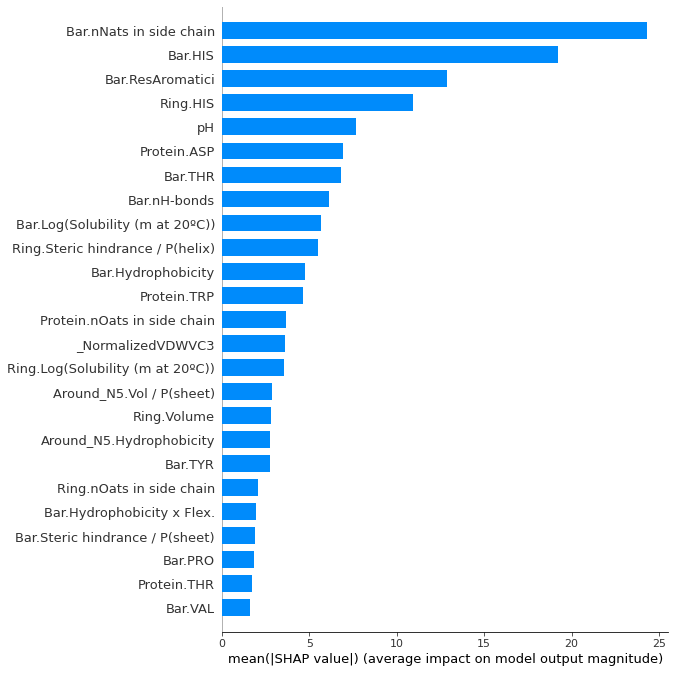

In [13]:
shap.summary_plot(shap_values, X2_df, plot_type='bar', feature_names=features_graph, max_display=25)

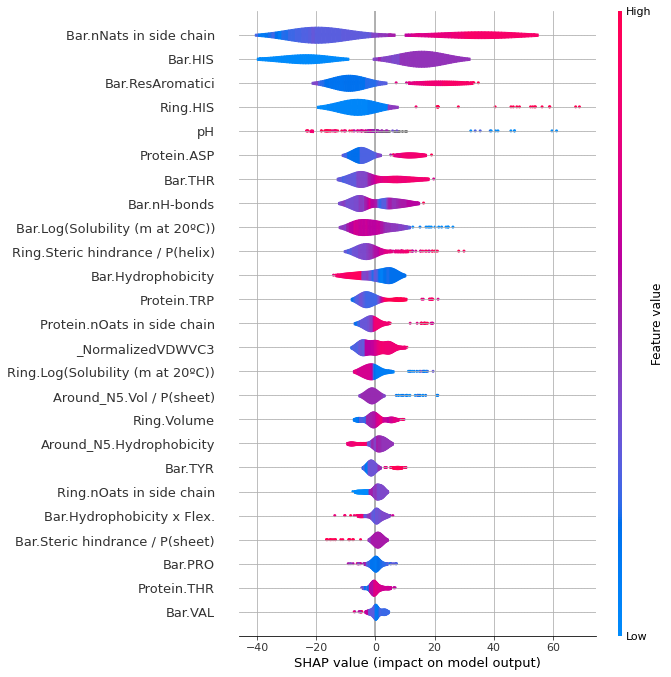

In [14]:
plt.grid(b=None)
shap.summary_plot(shap_values, subset ,feature_names=features_graph,max_display=25,plot_type="violin")

In [15]:
shap.initjs()
shap.force_plot(
                explainer.expected_value,
                shap_values,
                subset,
                feature_names=features_graph
               )